In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot

In [2]:
def ConvertEventToNumpy(dfs, event):
    data = np.zeros(16)
    for i in range(16):
        if i in dfs:
            data[i] = dfs[i].loc[event]["amplitude"]
    data.shape = (4,4)
    return data

In [37]:
def GetAmplitudeFTSeedPixel(dfs, event, pixels = list(range(16))):
    maxAmplitude = 0
    maxPixel = -1
    falltimeSeed=0
    for i in pixels:
        if i in dfs:
            amplitude = dfs[i].loc[event]["amplitude"]
            falltime= dfs[i].loc[event]["fallTime"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
                if (i==5 or i==6 or i==9 or i==10):
                    falltimeSeed=falltime
    if (maxPixel != 5 and maxPixel != 6 and maxPixel != 9 and maxPixel != 10):
        falltimeSeed=-9999
        
    return maxPixel, maxAmplitude,falltimeSeed

In [38]:
def GetElectronsSeedPixel(dfs, event, pixels = [5,6,9,10]):
    maxAmplitude = 0
    maxPixel = -1
    for i in pixels:
        if i in dfs:
            amplitude = dfs[i].loc[event]["electrons"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
    return maxPixel, maxAmplitude

In [98]:
df = uproot.open("ITS3/Data/run175174828_230428174901_preprocessed2.root")["PreprocessedData"]
nPixels = 16
dfs = {}

for i in range(nPixels):
    dfs[i] = df[f"pixel{i}"].arrays(library="pd")
dfs

{0:        pixel  samplingPeriod    baseline  minLevel     t10     t90     t50   
 0          0          250000  238.437040  235.7628 -9999.0 -9999.0 -9999.0  \
 1          0          250000  238.624301  236.3724 -9999.0 -9999.0 -9999.0   
 2          0          250000  238.652876  235.6485 -9999.0 -9999.0 -9999.0   
 3          0          250000  238.822230  236.6391 -9999.0 -9999.0 -9999.0   
 4          0          250000  238.765271  236.4105 -9999.0 -9999.0 -9999.0   
 ...      ...             ...         ...       ...     ...     ...     ...   
 47095      0          250000  236.597001  234.5055 -9999.0 -9999.0 -9999.0   
 47096      0          250000  236.844650  233.4768 -9999.0 -9999.0 -9999.0   
 47097      0          250000  237.436534  234.6960 -9999.0 -9999.0 -9999.0   
 47098      0          250000  236.758353  234.3150 -9999.0 -9999.0 -9999.0   
 47099      0          250000  237.121256  234.2007 -9999.0 -9999.0 -9999.0   
 
        fallTime  amplitude  electrons  RMS  
 

<Axes: ylabel='Frequency'>

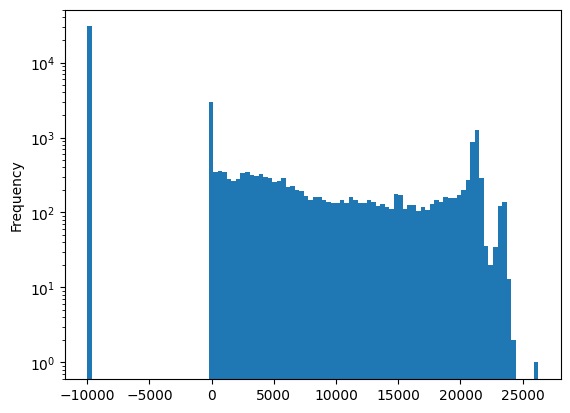

In [99]:
plt.yscale('log')
dfs[5]["electrons"].plot.hist(bins=100)


(6, 50.51179125934992, nan)
(9, 24.538238619461378, 1747.6397475706908)


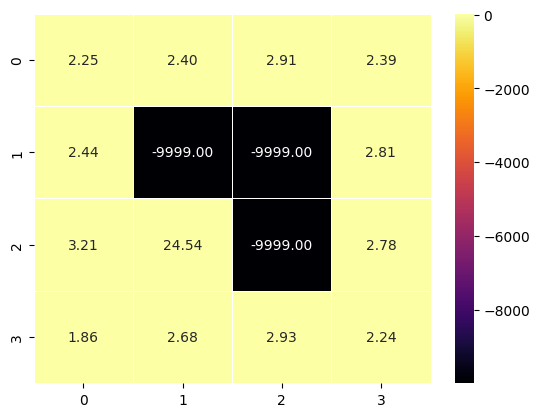

In [100]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs[0])):
    print(GetAmplitudeFTSeedPixel(dfs, i))
    if GetAmplitudeFTSeedPixel(dfs, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

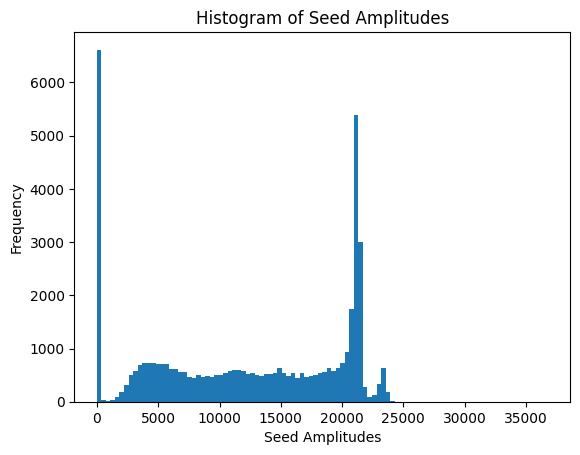

In [101]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetElectronsSeedPixel(dfs, i, pixels=[5,6,9,10])[1])
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.show()


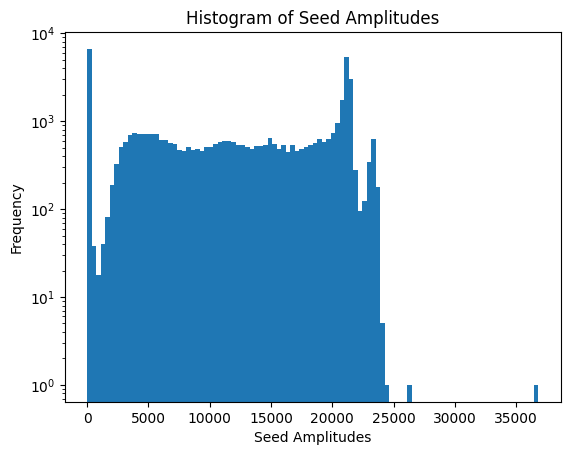

In [102]:
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.yscale('log')
plt.show()


In [103]:
def clusterize(dfs, event, threshold):
    data = ConvertEventToNumpy(dfs, event)
    cluster = np.zeros(16)
    NClusters = 0
    for i in range(4):
        for j in range(4):
            if data[i][j] > threshold:
                cluster[i*4+j] = 1
                NClusters += 1
    cluster.shape = (4,4)
    return cluster, NClusters

In [104]:
ClusterDistribution = []
for i in range(len(dfs[0])):
    ClusterDistribution.append(clusterize(dfs, i, 10)[1])



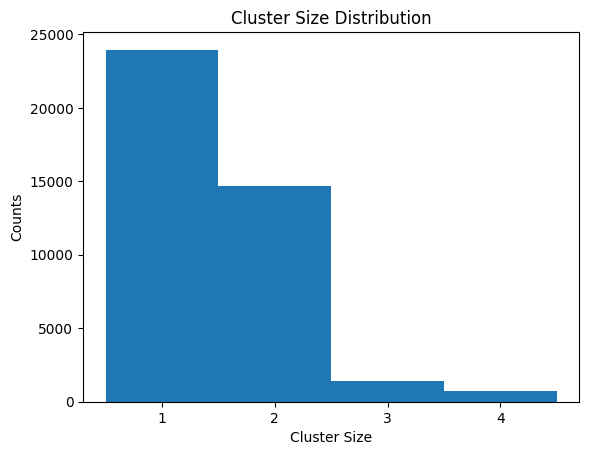

In [105]:
plt.hist(ClusterDistribution, bins=[0.5,1.5,2.5,3.5,4.5])
plt.xticks([1, 2, 3, 4])
plt.xlabel('Cluster Size')
plt.ylabel('Counts')
plt.title('Cluster Size Distribution')
plt.show()

In [106]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetElectronsSeedPixel(dfs, i)[1])
SeedAmplitudes = np.array(SeedAmplitudes)

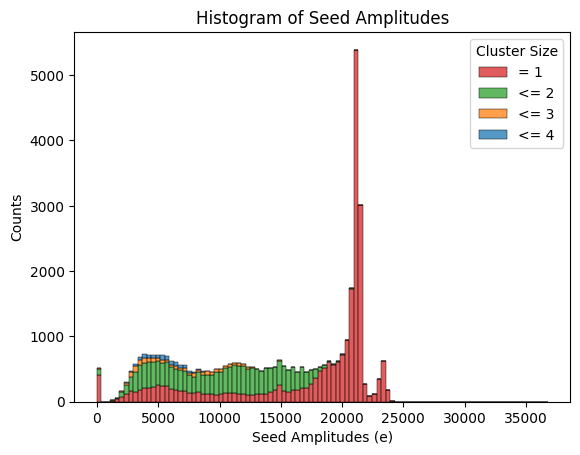

In [107]:
df_amplitudes_size = pd.DataFrame({"amplitude": SeedAmplitudes, "size": ClusterDistribution})
df_amplitudes_size['size'] = pd.Categorical(df_amplitudes_size['size'], [4,3,2,1])
sns.histplot(data = df_amplitudes_size, x="amplitude", hue="size", bins=100, multiple="stack")
# Set the legend labels in the desired order
legend_order = ['= 1', '<= 2', '<= 3', '<= 4']
plt.legend(title='Cluster Size', labels=legend_order)
plt.xlabel('Seed Amplitudes (e)')
plt.ylabel('Counts')
plt.title('Histogram of Seed Amplitudes')
plt.show()

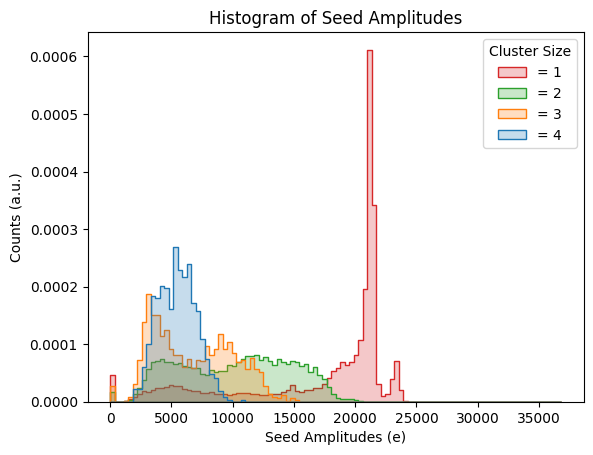

In [108]:
df_amplitudes_size = pd.DataFrame({"amplitude": SeedAmplitudes, "size": ClusterDistribution})
df_amplitudes_size['size'] = pd.Categorical(df_amplitudes_size['size'], [4,3,2,1])
sns.histplot(data = df_amplitudes_size, x="amplitude", hue="size", bins=100, multiple="layer", element="step",stat="density", common_norm=False,)
# Set the legend labels in the desired order
legend_order = ['= 1', '= 2', '= 3', '= 4']
plt.legend(title='Cluster Size', labels=legend_order)
plt.xlabel('Seed Amplitudes (e)')
plt.ylabel('Counts (a.u.)')
plt.title('Histogram of Seed Amplitudes')
plt.show()

In [109]:
#falltime of seed pixel vs cluster size
SeedFalltime = []
for i in range(len(dfs[0])):
    SeedFalltime.append(GetAmplitudeFTSeedPixel(dfs, i)[2])
SeedFalltime = np.array(SeedFalltime)


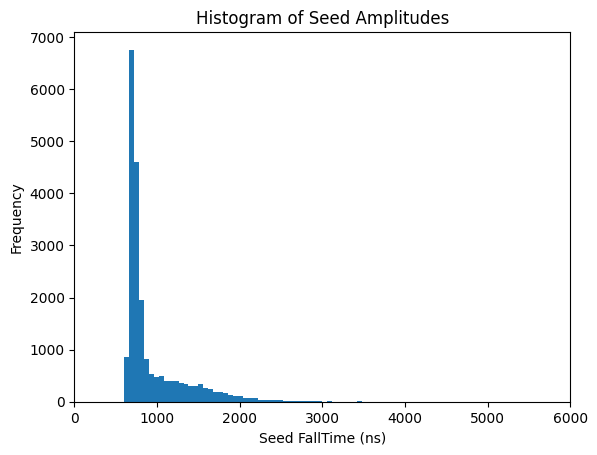

In [120]:
min_val = 0
max_val = 6000

# Create bins for SeedFalltime using linspace
bins_y = np.linspace(min_val, max_val, 101)  # +1 to include both ends
plt.hist(SeedFalltime,bins_y)
plt.xlabel('Seed FallTime (ns)')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
#plt.yscale('log')
plt.xlim(0, 6000)
plt.show()

In [121]:
clean_cluster = []
clean_falltime = []
clean_Amplitudes= []

# Iterate through ClusterDistribution and SeedFalltime to filter NaN values
for i in range(len(ClusterDistribution)):
    if not np.isnan(ClusterDistribution[i]) and not np.isnan(SeedFalltime[i]):
        clean_cluster.append(ClusterDistribution[i])
        clean_falltime.append(SeedFalltime[i])
        clean_Amplitudes.append(SeedAmplitudes[i])

# Convert the lists to NumPy arrays
SeedAmplitudes = np.array(clean_Amplitudes)
ClusterDistribution = np.array(clean_cluster)
SeedFalltime = np.array(clean_falltime)

Text(0.5, 1.0, 'Seed Falltime vs cluster size')

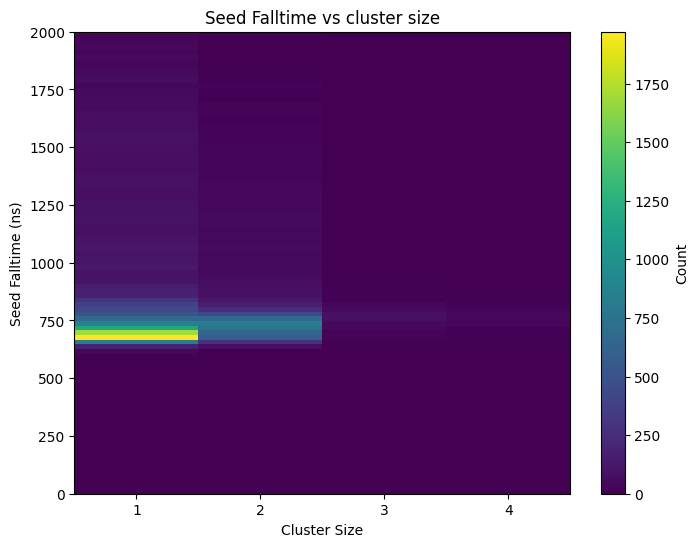

In [126]:
plt.figure(figsize=(8, 6))
bins_y = np.linspace(0, 2000, 100)
hist, xedges, yedges, image = plt.hist2d(ClusterDistribution, SeedFalltime, bins=([0.5,1.5,2.5,3.5,4.5],bins_y ), cmap='viridis')
plt.xticks([1, 2, 3, 4])
#plt.ylim(500, 1200)
# Adding color legend
plt.colorbar(image, label='Count')

plt.xlabel('Cluster Size')
plt.ylabel('Seed Falltime (ns)')
plt.title('Seed Falltime vs cluster size')

Text(0.5, 1.0, 'Seed Amplitude vs cluster size')

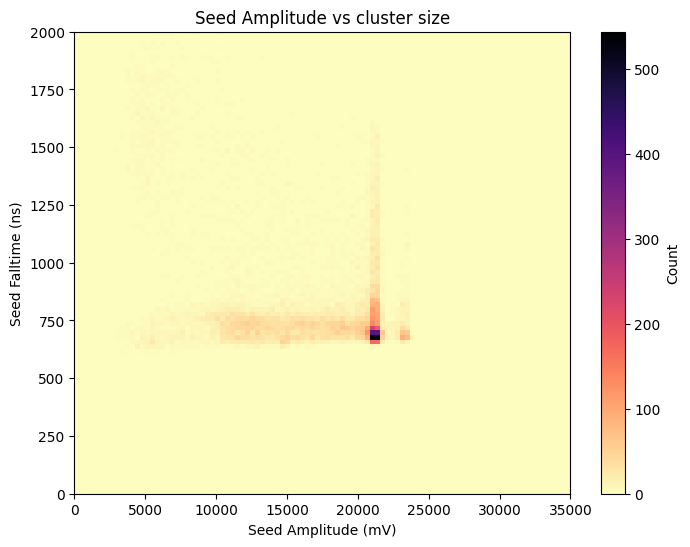

In [128]:
#falltime of seed pixel vs amplitude of seed pixel
plt.figure(figsize=(8, 6))
bins_y = np.linspace(0, 2000, 100)
bins_x= np.linspace(0, 35000, 100)
hist, xedges, yedges, image = plt.hist2d(SeedAmplitudes, SeedFalltime, bins=(bins_x,bins_y ), cmap='magma_r')
# Adding color legend
plt.colorbar(image, label='Count')

plt.xlabel('Seed Amplitude (mV)')
plt.ylabel('Seed Falltime (ns)')
plt.title('Seed Amplitude vs cluster size')

In [130]:
df_falltime_size = pd.DataFrame({"fallTime": SeedFalltime, "size": ClusterDistribution})
df_falltime_size['size'] = pd.Categorical(df_falltime_size['size'], [4,3,2,1])
sns.histplot(data = df_falltime_size, x="fallTime", hue="size", bins=100, multiple="layer", element="step",stat="density", common_norm=False,)
# Set the legend labels in the desired order
legend_order = ['= 1', '= 2', '= 3', '= 4']
plt.legend(title='Cluster Size', labels=legend_order)
plt.xlabel('Seed falltime (e)')
plt.ylabel('Counts (a.u.)')
plt.title('Histogram of Seed falltime')
plt.show()

ValueError: Could not interpret value `amplitude` for `x`. An entry with this name does not appear in `data`.